In [21]:
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns

# DATA - GETTING AND PREPROCESSING

In [22]:
input_directory = "original_dataset"
output_directory = "datasets"

if not os.path.exists(output_directory):
    splitfolders.ratio(input_directory, 
                       output=output_directory,
                       ratio=(0.85, 0.1,0.05)) 

In [23]:
def get_image_generator (preprocessing_function, horizontal_flip, vertical_flip, rotation_range, zoom_range, width_shift_range,height_shift_range,shear_range, featurewise_std_normalization,brightness_range, rescale):
    
    image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                         horizontal_flip=horizontal_flip,
                                         vertical_flip= vertical_flip,
                                         rotation_range=rotation_range,
                                         zoom_range=zoom_range,
                                         width_shift_range=width_shift_range,
                                         height_shift_range=height_shift_range,
                                         shear_range=shear_range,
                                         featurewise_std_normalization=featurewise_std_normalization,
                                         brightness_range=brightness_range,
                                         rescale = rescale)
    
    return image_generator

In [24]:
train_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                            horizontal_flip=True,
                                            vertical_flip=False,
                                            rotation_range=10,
                                            zoom_range=0.15,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            shear_range=0.15,
                                            featurewise_std_normalization=False,
                                            brightness_range=[0.9, 1.1],
                                            rescale = None)

val_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                          horizontal_flip=False,
                                          vertical_flip=False,
                                          rotation_range=0,
                                          zoom_range=0.0,
                                          width_shift_range=0.0,
                                          height_shift_range=0.0,
                                          shear_range=0.0,
                                          featurewise_std_normalization=False,
                                          brightness_range=None,
                                          rescale = None)

test_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           rotation_range=0,
                                           zoom_range=0.0,
                                           width_shift_range=0.0,
                                           height_shift_range=0.0,
                                           shear_range=0.0,
                                           featurewise_std_normalization=False,
                                           brightness_range=None,
                                           rescale = None)

In [25]:
def get_data_set(directory, image_generator, target_size, batch_size=32): 

    data_set = image_generator.flow_from_directory(directory=directory, 
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   class_mode='categorical')

    
    return data_set 

In [26]:
datasets_directory = os.path.join(os.getcwd(), output_directory)
train_dataset_directory = os.path.join(datasets_directory, "train")
val_dataset_directory = os.path.join(datasets_directory, "val")
test_dataset_directory = os.path.join(datasets_directory, "test")

In [27]:
target_size = (224,224)
batch_size = 32

train_dataset = get_data_set(train_dataset_directory,
                             train_image_generator, 
                             target_size=target_size,
                             batch_size=batch_size)

test_dataset = get_data_set(test_dataset_directory,
                            test_image_generator, 
                            target_size=target_size,
                            batch_size=batch_size)

val_dataset = get_data_set(val_dataset_directory,
                           val_image_generator, 
                           target_size=target_size,
                           batch_size=batch_size)

Found 1555 images belonging to 12 classes.
Found 103 images belonging to 12 classes.
Found 177 images belonging to 12 classes.


# DATA VISUALIZATION AND ANALYSIS

In [28]:
def show_images(data_batch, labels, nrows, ncols, batch_size):    

    images_batch = np.array(data_batch[0])
    labels_batch = np.array(data_batch[1] )
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(20,10))
    axes = axes.flatten()
    
    index = 0
    
    for ax in axes:
        if index < batch_size:
            image = images_batch[index]
            image=((image/1/255.)+1)/2
            ax.imshow(image)
            title = labels[np.argmax(labels_batch[index])]
            ax.set_title(title)
            plt.tight_layout()
            ax.set_axis_off()
            index += 1
        else: 
            break  

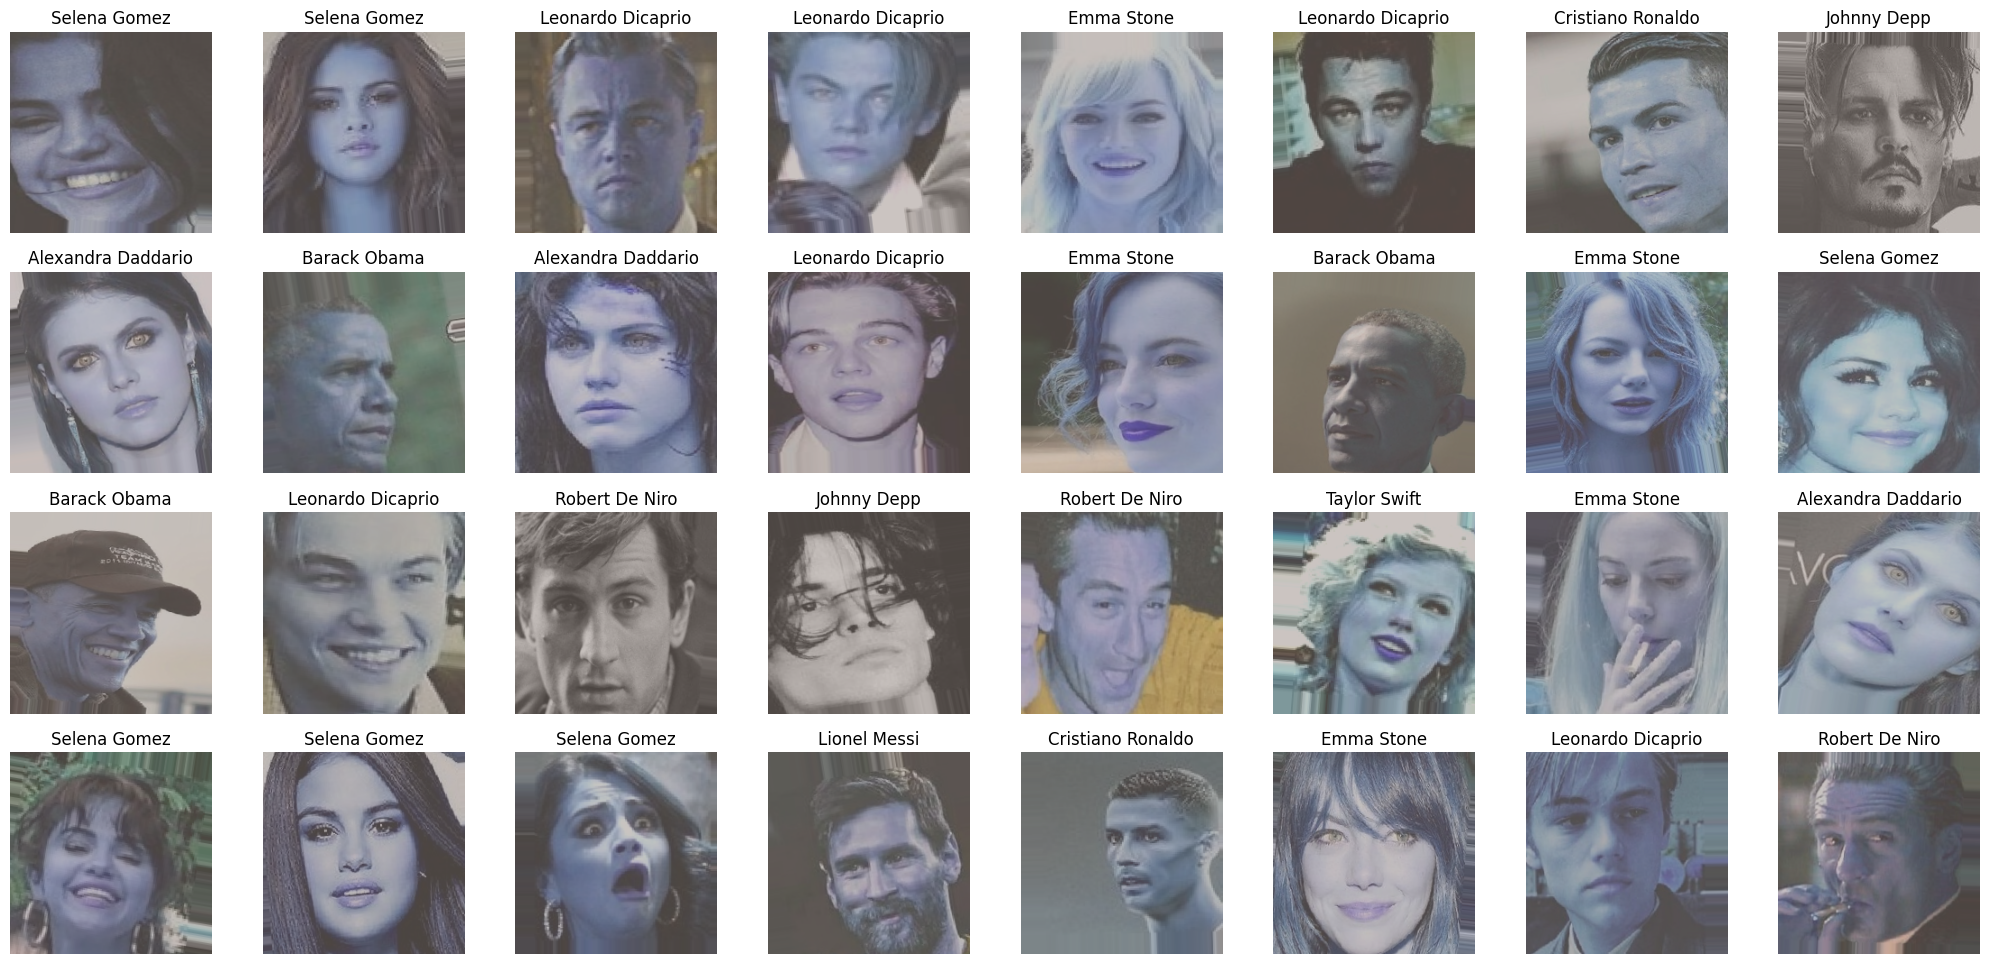

In [29]:
images_batch = next(train_dataset)
labels = {value : key.split("_")[1].title() for key, value in train_dataset.class_indices.items()}
nrows = 4
ncols=8

show_images(images_batch, labels, nrows, ncols, batch_size)

In [30]:
def get_number_of_elements_in_classes_as_df (dataset, labels):
    classes_size = Counter(dataset.classes)
    classes_labels_and_size_dict = {labels[key] : classes_size[key] for key in classes_size}
    classes_labels_and_size_df = pd.DataFrame(index = classes_labels_and_size_dict.keys(), 
                                              columns = ["Number_of_images"], 
                                              data = classes_labels_and_size_dict.values())
    return classes_labels_and_size_df

In [31]:
classes_labels_and_size_df = get_number_of_elements_in_classes_as_df (train_dataset, labels)

In [32]:
classes_labels_and_size_df

,Number_of_images
Alexandra Daddario,191
Bill Gates,103
Cristiano Ronaldo,83
Emma Stone,118
Johnny Depp,154
Leonardo Dicaprio,201
Lionel Messi,73
Robert De Niro,132
Selena Gomez,158
Shakira Isabel Mebarak,130


In [33]:
def plot_barplot_of_classes_and_elements(df):
    plt.figure(figsize=(20, 10))
    sns.barplot(x = df.index, y=df.columns[0], data = df)
    plt.xticks(rotation = 45)
    plt.title("Number of elements for each class")
    plt.show()

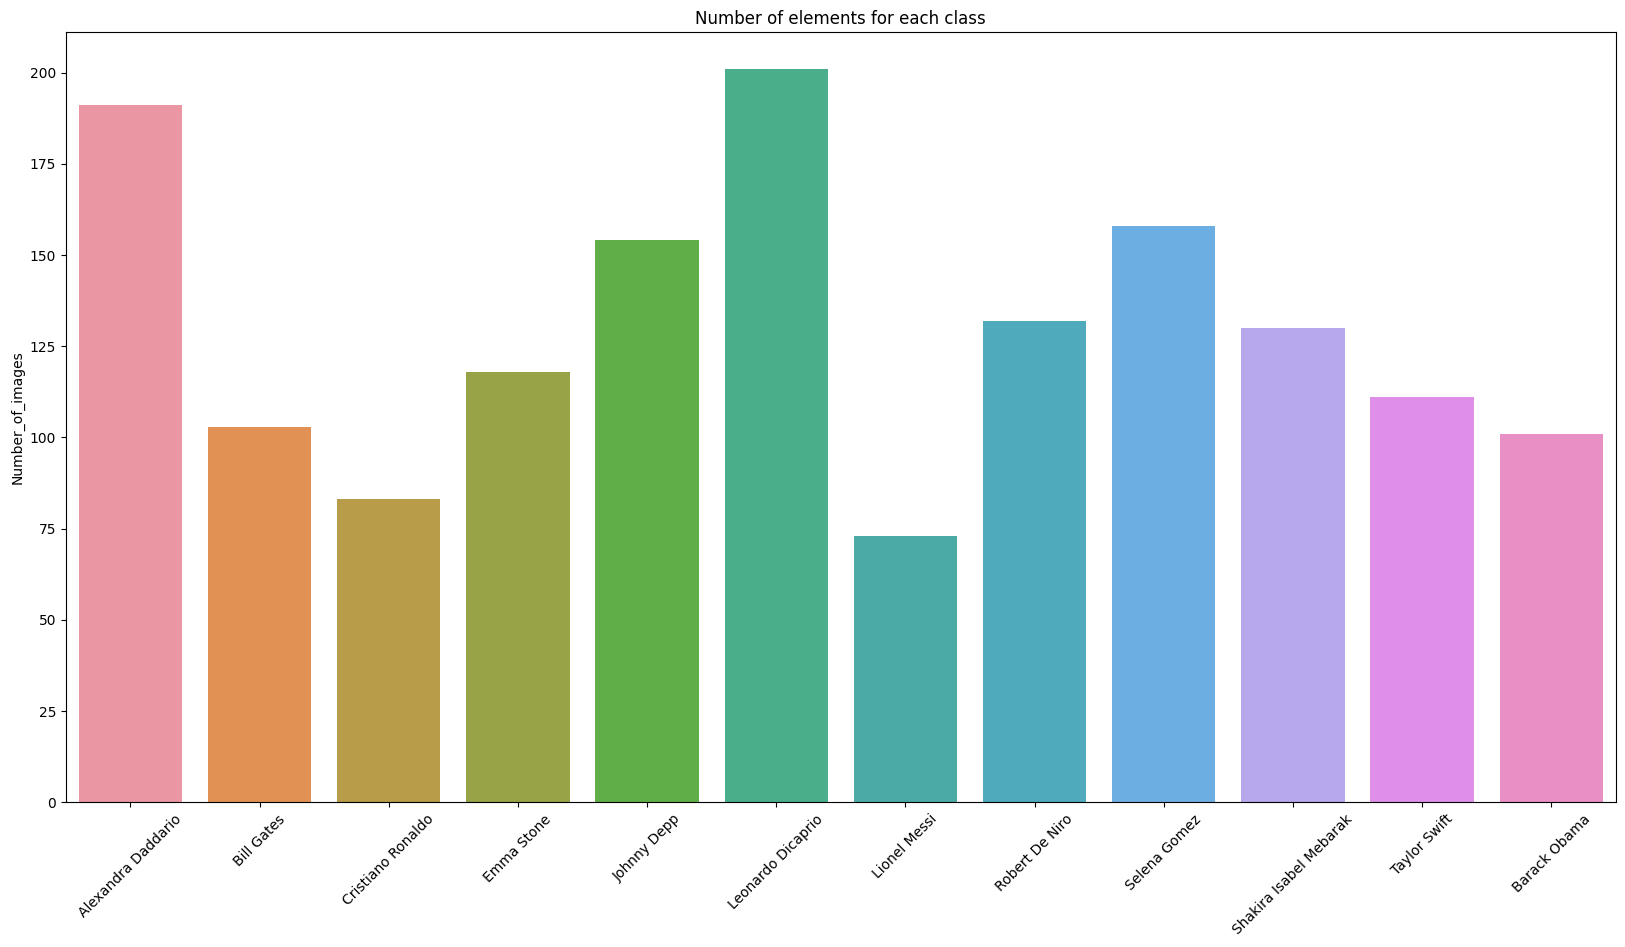

In [34]:
plot_barplot_of_classes_and_elements(classes_labels_and_size_df)